In [16]:
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTEN, ADASYN
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

file_path = "data/CRFs.csv"

In [17]:
df = pd.read_csv(file_path)
df = df.replace("n/a", np.nan).dropna()
df['Gender'] = df['Gender'].str.upper()
continuous_cols = ['Age','Weight','Height','SBP','DBP']
categorical_cols = ['Smoker', 'Gender']
target_col = 'Vascular event'
X = df.drop(columns=[target_col])
y = df[target_col]

In [18]:
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(X[continuous_cols])
X_cont_scaled = pd.DataFrame(X_cont_scaled, columns=continuous_cols)
encoder = OrdinalEncoder()
X_cat_encoded = encoder.fit_transform(X[categorical_cols])
X_cat_encoded = pd.DataFrame(X_cat_encoded, columns=categorical_cols)

In [19]:
X_cont_scaled.head()

,Age,Weight,Height,SBP,DBP
0,-2.221466,2.194940,1.746673,0.131399,0.485540
1,1.138972,0.176409,-0.359956,1.950732,-0.071100
2,0.718917,0.822339,1.465789,0.131399,1.042181
3,-0.821283,0.176409,0.904021,-1.343736,-1.184381
4,1.699045,-0.469520,0.342253,-0.852025,-0.627741


In [20]:
X_cat_encoded.head()

,Smoker,Gender
0,1.0,1.0
1,0.0,0.0
2,0.0,1.0
3,0.0,0.0
4,0.0,1.0


In [21]:
print("Original class distribution:")
print(pd.Series(y).value_counts())

Original class distribution:
Vascular event
none                     104
myocardial infarction      9
stroke                     3
syncope                    3
Name: count, dtype: int64


In [22]:
adasyn = ADASYN(sampling_strategy='not majority',n_neighbors=2, random_state=42)
X_cont_res, y_cont_res = adasyn.fit_resample(X_cont_scaled, y)
print("After ADASYN (continuous features):")
print(pd.Series(y_cont_res).value_counts())

After ADASYN (continuous features):
Vascular event
myocardial infarction    108
stroke                   105
syncope                  105
none                     104
Name: count, dtype: int64


In [23]:
vals = pd.Series(y_cont_res).value_counts()
smote_oversample = {
    'myocardial infarction':vals.values[0],
    'stroke':vals.stroke,
    'syncope':vals.syncope,
    'none':vals.none
}
smoten = SMOTEN(sampling_strategy=smote_oversample,k_neighbors=2, random_state=42)
X_cat_res, y_cat_res = smoten.fit_resample(X_cat_encoded, y)
print("After SMOTEN (categorical features):")
print(pd.Series(y_cat_res).value_counts())
if np.array_equal(y_cont_res, y_cat_res):
    X_res = pd.concat([X_cont_res.reset_index(drop=True),
                       X_cat_res.reset_index(drop=True)], axis=1)
    y_res = y_cont_res.reset_index(drop=True)
else:
    X_res = pd.concat([X_cont_res.reset_index(drop=True),
                       X_cat_res.reset_index(drop=True)], axis=1)
    y_res = y_cont_res.reset_index(drop=True)

After SMOTEN (categorical features):
Vascular event
myocardial infarction    108
stroke                   105
syncope                  105
none                     104
Name: count, dtype: int64


In [24]:
X_res.head()

,Age,Weight,Height,SBP,DBP,Smoker,Gender
0,-2.221466,2.194940,1.746673,0.131399,0.485540,1.0,1.0
1,1.138972,0.176409,-0.359956,1.950732,-0.071100,0.0,0.0
2,0.718917,0.822339,1.465789,0.131399,1.042181,0.0,1.0
3,-0.821283,0.176409,0.904021,-1.343736,-1.184381,0.0,0.0
4,1.699045,-0.469520,0.342253,-0.852025,-0.627741,0.0,1.0


In [25]:
y_res.head()

0    none
1    none
2    none
3    none
4    none
Name: Vascular event, dtype: object

In [26]:
augmented_data = pd.concat([X_res, y_res], axis=1)
augmented_data.head()

,Age,Weight,Height,SBP,DBP,Smoker,Gender,Vascular event
0,-2.221466,2.194940,1.746673,0.131399,0.485540,1.0,1.0,none
1,1.138972,0.176409,-0.359956,1.950732,-0.071100,0.0,0.0,none
2,0.718917,0.822339,1.465789,0.131399,1.042181,0.0,1.0,none
3,-0.821283,0.176409,0.904021,-1.343736,-1.184381,0.0,0.0,none
4,1.699045,-0.469520,0.342253,-0.852025,-0.627741,0.0,1.0,none


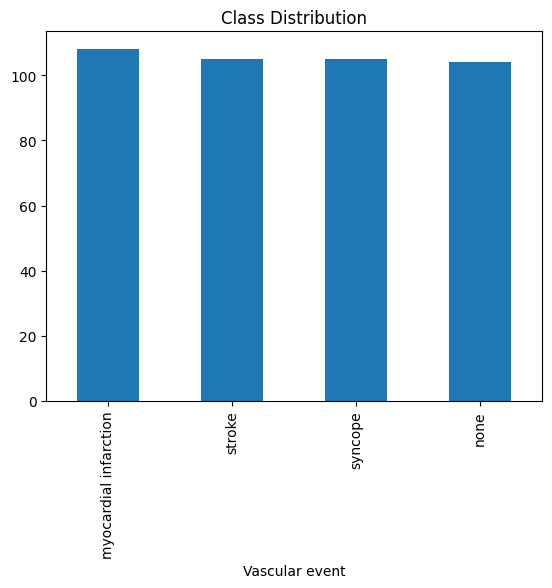

In [ ]:
augmented_data['Vascular event'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()
augmented_data.to_csv("augmented_dataset.csv", index=False)

In [74]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, dataloader
print(torch.cuda.is_available())
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [29]:
df.head()

,Record,Gender,Age,Weight,Height,BSA,BMI,Smoker,SBP,DBP,IMT MAX,LVMi,EF,Vascular event
0,1911,M,56,105,180,2.29,32.41,yes,140.0,80.0,4.0,123.0,66.0,none
2,2019,F,80,80,165,1.91,29.38,no,177.0,75.0,2.5,164.0,56.0,none
3,2020,M,77,88,178,2.09,27.77,no,140.0,85.0,2.7,115.0,67.0,none
4,2025,F,66,80,174,1.97,26.42,no,110.0,65.0,1.5,98.0,66.0,none
5,2031,M,84,72,170,1.84,24.91,no,120.0,70.0,2.6,147.0,51.0,none


In [34]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(augmented_data)
model = TVAESynthesizer(metadata=metadata, epochs=3000, cuda=True, verbose=True)
model.fit(augmented_data)
model.save("TVAE_model.pkl")


/home/elukbog/Projects/MEng-Project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/elukbog/Projects/MEng-Project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Loss: -17.713: 100%|██████████| 3000/3000 [00:56<00:00, 52.87it/s]


In [52]:
tvae_crf_samples = model.sample(30000)

In [59]:
labels = tvae_crf_samples['Vascular event']
indices = np.arange(len(tvae_crf_samples))
train_indices, temp_indices = train_test_split(indices, test_size=0.25, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)
train_crf_df = tvae_crf_samples.iloc[train_indices].copy()
val_crf_df   = tvae_crf_samples.iloc[val_indices].copy()
test_crf_df  = tvae_crf_samples.iloc[test_indices].copy()
train_labels = labels.iloc[train_indices].copy()
val_labels   = labels.iloc[val_indices].copy()
test_labels  = labels.iloc[test_indices].copy()
train_crf_df = train_crf_df.drop(columns=['Vascular event'])
val_crf_df   = val_crf_df.drop(columns=['Vascular event'])
test_crf_df  = test_crf_df.drop(columns=['Vascular event'])
train_crf_np = train_crf_df.to_numpy()
val_crf_np   = val_crf_df.to_numpy()
test_crf_np  = test_crf_df.to_numpy()
train_crf_tensor = torch.tensor(train_crf_np, dtype=torch.float32)
val_crf_tensor   = torch.tensor(val_crf_np, dtype=torch.float32)
test_crf_tensor  = torch.tensor(test_crf_np, dtype=torch.float32)

print("Train CRF tensor shape:", train_crf_tensor.shape)
print("Validation CRF tensor shape:", val_crf_tensor.shape)
print("Test CRF tensor shape:", test_crf_tensor.shape)

Train CRF tensor shape: torch.Size([22500, 7])
Validation CRF tensor shape: torch.Size([3750, 7])
Test CRF tensor shape: torch.Size([3750, 7])


In [60]:
train_labels = train_labels.str.lower().map(
        {'none': 0, 'myocardial infarction': 1, 'stroke': 2, 'syncope': 3})
test_labels = test_labels.str.lower().map(
        {'none': 0, 'myocardial infarction': 1, 'stroke': 2, 'syncope': 3})
val_labels = val_labels.str.lower().map(
        {'none': 0, 'myocardial infarction': 1, 'stroke': 2, 'syncope': 3})
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
print("Train labels tensor shape:", train_labels_tensor.shape)
print("Validation labels tensor shape:", val_labels_tensor.shape)
print("Test labels tensor shape:", test_labels_tensor.shape)

Train labels tensor shape: torch.Size([22500])
Validation labels tensor shape: torch.Size([3750])
Test labels tensor shape: torch.Size([3750])


In [63]:
class Generator(nn.Module):
    '''
    Generator model for the WGAN-GP-DTW model. \\
    Consists of a twin stack of bidirectional LSTMs with 75 hidden units each \\
    and 5 
    '''

    def __init__(self, ecg_length=640, n_leads=3, latent_dim=50, condition_dim=1):
        super(Generator, self).__init__()
        self.ecg_length = ecg_length
        self.latent_dim = latent_dim
        self.n_leads = n_leads
        self.condition_dim = condition_dim
        self.fc = nn.Linear(latent_dim + condition_dim, ecg_length * 32)
        self.cnn1 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64,
                      kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128,
                      kernel_size=7, padding=3),
            nn.ReLU()
        )
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128,
                             num_layers=1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128,
                             num_layers=1, batch_first=True, bidirectional=True)
        self.layer_norm = nn.LayerNorm(256)
        self.cnn2 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=192,
                      kernel_size=25, padding=12, stride=1),
            nn.LeakyReLU(0.2),
            nn.InstanceNorm1d(192, affine=True),
            nn.Conv1d(in_channels=192, out_channels=128,
                      kernel_size=17, padding=(17-1)//2, stride=1),
            nn.LeakyReLU(0.2),
            nn.InstanceNorm1d(128, affine=True),
            nn.Conv1d(in_channels=128, out_channels=64,
                      kernel_size=17, padding=(17-1)//2, stride=1),
            nn.LeakyReLU(0.2),
            nn.InstanceNorm1d(64, affine=True),
            nn.Conv1d(in_channels=64, out_channels=32,
                      kernel_size=17, padding=(17-1)//2, stride=1),
            nn.LeakyReLU(0.2),
            nn.InstanceNorm1d(32, affine=True),
            nn.Conv1d(in_channels=32, out_channels=n_leads,
                      kernel_size=17, padding=(17-1)//2, stride=1),
            nn.Tanh()
        )
        self.condition_embedding = nn.Embedding(4, self.condition_dim)

    def forward(self, noise, condition):
        cond_emb = self.condition_embedding(condition.squeeze(1))
        combined = torch.cat((noise, cond_emb), dim=1)
        x = self.fc(combined)
        x = x.view(-1, 32, self.ecg_length)
        x = self.cnn1(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = self.layer_norm(x)
        x, _ = self.lstm2(x)
        x = self.layer_norm(x)
        x = x.permute(0, 2, 1)  # Convert back to (batch, channels, time)
        x = self.cnn2(x)
        x = x.permute(0, 2, 1)  # Convert back to (batch, time, leads)
        return x

In [70]:
generator = Generator(ecg_length=640,n_leads=3,latent_dim=50)
CGAN_model = torch.load("gan_scripts/gan/CWGAN_models/cwgan_5/CWGAN.pth", map_location=device, weights_only=False)
generator.load_state_dict(CGAN_model['generator_state_dict'])
def generate_ecgs_for_crf(label_tensor, generator, noise_dim, batch_size, device):
    generator.to(device)
    generator.eval()
    num_samples = label_tensor.shape[0]
    generated_signals = []
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_conditions = label_tensor[i:i + batch_size].to(device)
            current_batch_size = batch_conditions.shape[0]
            noise = torch.randn(current_batch_size, noise_dim, device=device)
            batch_ecgs = generator(noise, batch_conditions)
            generated_signals.append(batch_ecgs.cpu())

    return torch.cat(generated_signals, dim=0)

In [72]:
train_ecg = generate_ecgs_for_crf(train_labels_tensor.unsqueeze(1), generator, 50, batch_size, device)
val_ecg   = generate_ecgs_for_crf(val_labels_tensor.unsqueeze(1), generator, 50, batch_size, device)
test_ecg  = generate_ecgs_for_crf(test_labels_tensor.unsqueeze(1), generator, 50, batch_size, device)
print(train_ecg.shape)
print(val_ecg.shape)
print(test_ecg.shape)

torch.Size([22500, 640, 3])
torch.Size([3750, 640, 3])
torch.Size([3750, 640, 3])


In [75]:
train_dataset = TensorDataset(train_ecg, train_crf_tensor, train_labels_tensor)
valid_dataset = TensorDataset(val_ecg, val_crf_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_ecg, test_crf_tensor, test_labels_tensor)